In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
import netCDF4 as nc
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
import rasotools
# from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua4 as eua
# eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')

from inspect import getmembers, isfunction


from IPython.display import Image
from IPython.core.display import HTML 
import rasotools


no config found


In [2]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

# x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
# gauss=x/6+y/6
# clist=numpy.linspace(-1,1,26)
# plt.contourf(x,y,gauss,clist,cmap=cmnew)
# plt.colorbar()
# plt.show()
# print('ready')

def plt_trends(lla,pdict,var='_',bias='_', marker_size = 510, marker_shape = 's', alpha=0.8):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

    if 'scale' not in pdict.keys():
        pdict['scale']=2.0
    a = rasotools.plot._helpers.cost(lla[2],lla[1],lla[0])
    cost = np.sum(a)/len(a)

    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax._autoscaleXon = False
    ax._autoscaleYon = False

    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    plt.scatter(lla[2], lla[1], s=marker_size, alpha=alpha,
                c= lla[0],
                cmap=cmnew,
                vmin=-pdict['scale'],
                vmax=pdict['scale'],
                marker = marker_shape,
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='Trend '+pdict['units'], shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.title('Brightness Temperature ' + str(pdict['start'])+'-'+str(pdict['stop'])+', '+str(pdict['pl'])+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(len(lla[0])))
        
    try:
        os.mkdir('plots_new')
    except:
        pass
#     plt.savefig('plots_new/cuon_'+names[bias]+'_'+str(pdict['start'])+'-'+str(pdict['stop'])+'_'+str(pdict['pl']), bbox_inches='tight')
    plt.show()
    plt.close()



pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [12, 8]

def plot_world_map(file, mission_channel, marker_size = 510, marker_shape = 's', alpha = 0.8):
    trends = pickle.load( open( file, "rb" ) )
    lats = []
    lons = []
    vals = []
    minl = []
    maxl =[]

    for i in trends:
        if trends[i] >= 15:
            maxl.append([i, trends[i]])
        elif trends[i] <= -15:
            minl.append([i, trends[i]])
        else:
            lats.append(float( i.split('_')[0]))#trends[i].lat))
            lons.append(float( i.split('_')[1]))#trends[i].lon))
            vals.append(float(trends[i].values))
    # print(' --- dropped ---')
    # print(maxl)
    # print(minl)
    # /10. for K/10a
    plt_trends(np.array([np.array(vals)/10., np.array(lats), np.array(lons)]), dict(var='temperature',pl=mission_channel,start='1992',stop='2022',units=r'K/10a'), marker_size = marker_size, marker_shape = marker_shape, alpha=alpha)
#     rasotools.plot.map.points(lon=np.array(lons), lat=np.array(lats), values=np.array(vals), vmin=-5, vmax=5)
    plt.show()
    plt.close()

In [3]:
station = '/mnt/users/scratch/leo/scratch/converted_v13/long/0-20001-0-11035_CEUAS_merged_v1.nc'
df = eua.CDMDataset(filename = station).to_dataframe(
    groups=['observations_table', 'advanced_homogenisation'], 
    variables=['observed_variable', 'observation_value', 'date_time', 'z_coordinate', 'latitude', 'longitude','humidity_bias_estimate']
    )
df = df[np.isin(df.z_coordinate, [20000,25000,30000,40000,50000,70000,85000,92500])]
df = df.rename({'latitude':'lat','longitude':'lon', 'date_time':'time', 'z_coordinate':'plev'}, axis='columns')
all_dfsh = df[df.observed_variable == 138]
all_dfsh = all_dfsh.rename({'observation_value':'rh'}, axis='columns')

all_dfta = df[df.observed_variable == 126]
all_dfta = all_dfta.rename({'observation_value':'temperature'}, axis='columns')

df_target = pd.merge(all_dfsh, all_dfta, on=["time", "plev", "lat", "lon"])

In [4]:

df_target['sh'] = rasotools.met.convert.to_sh(temp=xr.DataArray(df_target.temperature), press=xr.DataArray(df_target.plev), rel_humi=xr.DataArray(df_target.rh)).values
df_target['sh'][np.logical_or((df_target['sh'] < 0.), (df_target['sh'] > 1.03))] = np.nan
df_target['sh_adj'] = rasotools.met.convert.to_sh(temp=xr.DataArray(df_target.temperature), press=xr.DataArray(df_target.plev), rel_humi=xr.DataArray(df_target.rh - df_target.humidity_bias_estimate_x)).values
df_target['sh_adj'][np.logical_or((df_target['sh_adj'] < 0.), (df_target['sh_adj'] > 1.03))] = np.nan
df_sh = df[df.observed_variable == 39]


## All the different specific humidities:

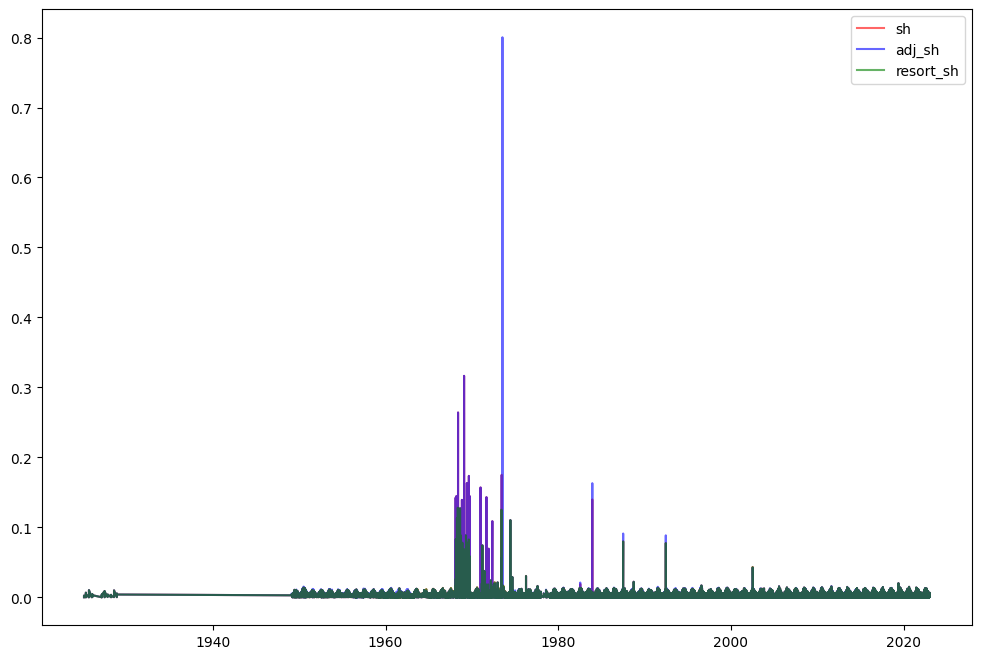

In [5]:
plt.plot(df_target.time, df_target.sh, color = 'red', alpha = 0.6, label='sh')
plt.plot(df_target.time, df_target.sh_adj, color = 'blue', alpha = 0.6, label='adj_sh')
plt.plot(df_sh.time, df_sh.observation_value,color = 'green', alpha = 0.6, label='resort_sh')
plt.legend()

## Subset of the different specific humidities:

In [6]:
plt.plot(df_target[np.logical_and(df_target.time > '1955' , df_target.time <'1960')].time, df_target[np.logical_and(df_target.time > '1955' , df_target.time <'1960')].sh, color = 'red', alpha = 0.6, label='sh')
plt.plot(df_target[np.logical_and(df_target.time > '1955' , df_target.time <'1960')].time, df_target[np.logical_and(df_target.time > '1955' , df_target.time <'1960')].sh_adj, color = 'blue', alpha = 0.6, label='adj_sh')
plt.plot(df_sh[np.logical_and(df_sh.time > '1955' , df_sh.time <'1960')].time, df_sh[np.logical_and(df_sh.time > '1955' , df_sh.time <'1960')].observation_value,color = 'green', alpha = 0.6, label='resort_sh')
plt.legend()

## Different specific humidities for the most :

In [7]:
plt.plot(df_target[np.logical_and(df_target.time > '1968' , df_target.time <'1970')].time, df_target[np.logical_and(df_target.time > '1968' , df_target.time <'1970')].sh, color = 'red', alpha = 0.6, label='sh')
plt.plot(df_target[np.logical_and(df_target.time > '1968' , df_target.time <'1970')].time, df_target[np.logical_and(df_target.time > '1968' , df_target.time <'1970')].sh_adj, color = 'blue', alpha = 0.6, label='adj_sh')
plt.plot(df_sh[np.logical_and(df_sh.time > '1968' , df_sh.time <'1970')].time, df_sh[np.logical_and(df_sh.time > '1968' , df_sh.time <'1970')].observation_value,color = 'green', alpha = 0.6, label='resort_sh')
plt.legend()

In [22]:
pd.to_datetime(df_target_sh['time_to_show'],format='%Y%m')

time  time  plev   
1     1925  20000.0   1925-01-01
            25000.0   1925-01-01
            30000.0   1925-01-01
            40000.0   1925-01-01
            50000.0   1925-01-01
                         ...    
12    2022  40000.0   2022-12-01
            50000.0   2022-12-01
            70000.0   2022-12-01
            85000.0   2022-12-01
            92500.0   2022-12-01
Name: time_to_show, Length: 6318, dtype: datetime64[ns]

## "good" check > 0:

In [51]:
df_target_sh = df_target
df_target_sh['time_to_show'] = df_target_sh.time
df_target_sh.index = pd.to_datetime(df_target_sh['time'],format='%y-%m/%d %I:%M%p')
df_target_sh_copy = copy.deepcopy(df_target_sh)
df_target_sh = df_target_sh.groupby(by=[df_target_sh.index.month, df_target_sh.index.year, 'plev']).aggregate({"sh":"mean"})
df_target_sh['count'] = df_target_sh_copy.groupby(by=[df_target_sh_copy.index.month, df_target_sh_copy.index.year, 'plev']).aggregate({'sh':'count'}).values
df_target_sh['time_to_show'] = np.char.add(np.array(df_target_sh.index.get_level_values(1)).astype('str') , np.char.zfill(np.array(df_target_sh.index.get_level_values(0)).astype('str'), 2))
df_target_sh['time_to_show'] = pd.to_datetime(df_target_sh['time_to_show'],format='%Y%m')

for pi in [20000,25000,30000,40000,50000,70000,85000,92500]:
    xs_sh = df_target_sh.xs(pi, level='plev')
    xs_sh.sort_values(by='time_to_show', inplace=True)
    xs_sh = xs_sh[xs_sh['count'] > 0]
    plt.plot(xs_sh.time_to_show, xs_sh.sh, alpha = 0.6, label='aggregated_sh_' + str(pi))
    # plt.title(str(pi) + ' Pa')
plt.legend()
plt.show()
plt.close()

## "good" check > 15:

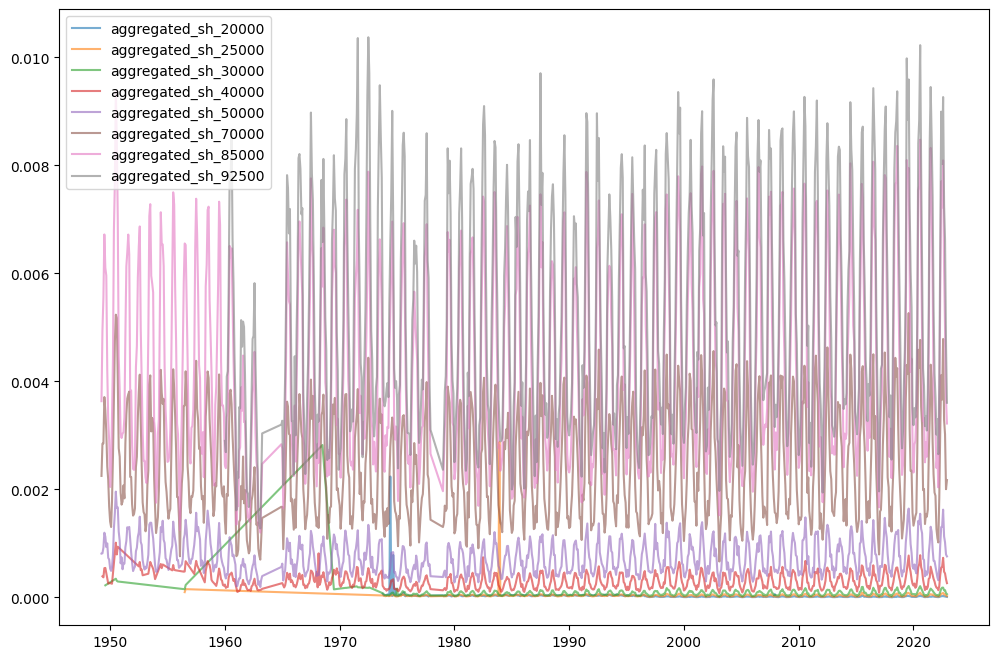

In [50]:
df_target_sh = df_target
df_target_sh['time_to_show'] = df_target_sh.time
df_target_sh.index = pd.to_datetime(df_target_sh['time'],format='%y-%m/%d %I:%M%p')
df_target_sh_copy = copy.deepcopy(df_target_sh)
df_target_sh = df_target_sh.groupby(by=[df_target_sh.index.month, df_target_sh.index.year, 'plev']).aggregate({"sh":"mean"})
df_target_sh['count'] = df_target_sh_copy.groupby(by=[df_target_sh_copy.index.month, df_target_sh_copy.index.year, 'plev']).aggregate({'sh':'count'}).values
df_target_sh['time_to_show'] = np.char.add(np.array(df_target_sh.index.get_level_values(1)).astype('str') , np.char.zfill(np.array(df_target_sh.index.get_level_values(0)).astype('str'), 2))
df_target_sh['time_to_show'] = pd.to_datetime(df_target_sh['time_to_show'],format='%Y%m')

for pi in [20000,25000,30000,40000,50000,70000,85000,92500]:
    xs_sh = df_target_sh.xs(pi, level='plev')
    xs_sh.sort_values(by='time_to_show', inplace=True)
    xs_sh = xs_sh[xs_sh['count'] > 15]
    plt.plot(xs_sh.time_to_show, xs_sh.sh, alpha = 0.6, label='aggregated_sh_' + str(pi))
    # plt.title(str(pi) + ' Pa')
plt.legend()
plt.show()
plt.close()

In [44]:
df_target_sh

sh  count
time time plev                    
1    1925 20000.0  0.000014      1
          25000.0  0.000028      1
          30000.0  0.000051      1
          40000.0  0.000172      1
          50000.0  0.000358      1
...                     ...    ...
12   2022 40000.0  0.000265     61
          50000.0  0.000760     61
          70000.0  0.002173     61
          85000.0  0.003220     61
          92500.0  0.003604     61

[6318 rows x 2 columns]

In [105]:
df_target_sh.xs()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
df_sh

In [41]:
ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax._autoscaleXon = False
ax._autoscaleYon = False

ax.add_feature(cfeature.OCEAN, zorder=0)
ax.coastlines()

plt.scatter(lla[2], lla[1], s=marker_size, alpha=alpha,
            c= lla[0],
            cmap=cmnew,
            vmin=-pdict['scale'],
            vmax=pdict['scale'],
            marker = marker_shape,
            edgecolor='k',)
plt.colorbar(orientation='horizontal', label='Trend '+pdict['units'], shrink=0.9, pad=0.05)
plt.tight_layout()
plt.title('Brightness Temperature ' + str(pdict['start'])+'-'+str(pdict['stop'])+', '+str(pdict['pl'])+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(len(lla[0])))

observed_variable_x        rh                time     plev  \
0                         138  0.280000 1925-01-24 09:22:00   4300.0   
1                         138  0.290000 1925-01-24 09:22:00   4400.0   
2                         138  0.283131 1925-01-24 09:22:00   5000.0   
3                         138  0.280000 1925-01-24 09:22:00   5300.0   
4                         138  0.280000 1925-01-24 09:22:00   7000.0   
...                       ...       ...                 ...      ...   
12146361                  138  0.792027 2022-12-31 11:30:23  99440.0   
12146362                  138  0.788326 2022-12-31 11:30:23  99470.0   
12146363                  138  0.784618 2022-12-31 11:30:23  99530.0   
12146364                  138  0.782605 2022-12-31 11:30:23  99540.0   
12146365                  138  0.802033 2022-12-31 11:30:23  99900.0   

                lat        lon  humidity_bias_estimate_x  observed_variable_y  \
0         48.248611  16.356388                       NaN                  126   
1         48.248611  16.356388                       NaN                  126   
2         48.248611  16.356388                       0.0                  126   
3         48.248611  16.356388                       0.0                  126   
4         48.248611  16.356388                       0.0                  126   
...             ...        ...                       ...                  ...   
12146361  48.248871  16.357590                       NaN                  126   
12146362  48.248871  16.357590                       NaN                  126   
12146363  48.248871  16.357590                       NaN                  126   
12146364  48.248871  16.357590                       NaN                  126   
12146365  48.248871  16.357590                       NaN                  126   

          temperature  humidity_bias_estimate_y        sh  
0          220.750000                       NaN  0.000198  
1          220.550003                       NaN  0.000196  
2          217.596344                       NaN  0.000119  
3          216.250000                       NaN  0.000094  
4          216.048218                       NaN  0.000070  
...               ...                       ...       ...  
12146361   279.660004                       NaN  0.004833  
12146362   279.799988                       NaN  0.004856  
12146363   279.920013                       NaN  0.004870  
12146364   280.049988                       NaN  0.004901  
12146365   280.350006                       NaN  0.005109  

[12146366 rows x 11 columns]

In [19]:
humfiles = glob.glob('/mnt/jetfs/scratch/uvoggenberger/rttov_out/humidity/bt2_0*.nc')

print(humfiles[0])
df = xr.open_dataset(humfiles[0], decode_times=False).to_dataframe()
df.datum.drop_duplicates()[0,0,0,0,0]

time_series = {}

for station in humfiles[:]:
    # print(station)
    df = xr.open_dataset(station, decode_times=False).to_dataframe()
    ts_index =  str(df.lat.iloc[0]) + '_' + str(df.lon.iloc[0])
    time_series[ts_index] = [[],[],[],[],[]]
    sel_df = df.loc(axis=0)[:, :, [0], :, [0]]
    time_series[ts_index][0].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].montemp.values)
    time_series[ts_index][1].append(df[np.logical_and(df.press == 4 , df.index.get_level_values('hour') == 0)].montemp.values)
    time_series[ts_index][2].append(df[np.logical_and(df.press == 5 , df.index.get_level_values('hour') == 0)].montemp.values)
    time_series[ts_index][3].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].datum.values)
    time_series[ts_index][4].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].goodmon.values)


trends_ch3 = {}
trends_ch4 = {}
trends_ch5 = {}
for lat_lon in time_series.keys():
    print(lat_lon, len(time_series[lat_lon][0][0]))
    if len(time_series[lat_lon][0][0]) < 10:
        continue
    df2 = pandas.DataFrame(np.transpose(
        [   np.array(time_series[lat_lon][0]).flatten(), 
        np.array(time_series[lat_lon][1]).flatten(), 
        np.array(time_series[lat_lon][2]).flatten(), 
        np.array(time_series[lat_lon][3]).flatten(), 
        np.array(time_series[lat_lon][4]).flatten(), 
        [float(lat_lon.split('_')[0])]*len(np.array(time_series[lat_lon][0]).flatten()), 
        [float(lat_lon.split('_')[1])]*len(np.array(time_series[lat_lon][0]).flatten())
        ]
        ), columns=['ch3', 'ch4', 'ch5', 'time', 'goodmon', 'lat', 'lon'])
    df2.time = [pd.to_datetime('1900-01-01') + pd.Timedelta(x, 'd') for x in df2.time]
    df2.drop_duplicates(subset='time', inplace=True)
    
    filter_array = np.logical_or((df2.goodmon < 15), np.logical_or(df2.time.dt.year < 1992 , df2.time.dt.year > 2022))
    # filter_array = np.logical_or((df2.goodmon < 15), np.logical_or(df2.time.dt.year < 1972 , df2.time.dt.year > 2002))
    df2.ch3[filter_array] = np.nan
    df2.ch4[filter_array] = np.nan
    df2.ch5[filter_array] = np.nan
    df2 = df2.dropna()

    if len(df2) > ((30*12)-24):
        # display(df2)
        xdf = df2.set_index(['time']).to_xarray()
        trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3,only_slopes=True)*len(df2.time)*12.*10.)
        trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4,only_slopes=True)*len(df2.time)*12.*10.)
        trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5,only_slopes=True)*len(df2.time)*12.*10.)

pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/hum_unadj_ch3_late.p", "wb" ) )
pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/hum_unadj_ch4_late.p", "wb" ) )
pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/hum_unadj_ch5_late.p", "wb" ) )

/mnt/jetfs/scratch/uvoggenberger/rttov_out/humidity/bt2_082244.nc
-2.43_-54.72 560
37.9_40.2 1088
41.97_21.65 52
47.73_130.97 272
62.91727_152.41629 1680
65.79598_87.99091 1768
15.52_44.18 88
36.04706_-115.1847 532
68.70825_-52.85238 1328
32.9_-80.03 1412
78.07_14.22 380
53.0839_158.58379 1848
-66.55711_93.00107 1916
60.36682_120.43084 1684
47.25977_11.35527 1312
33.28_-119.52 180
44.38_-98.22 68
27.33_117.47 2016
41.65689_-69.95888 1376
31.94278_-102.18972 800
45.37_90.53 112
26.83_100.22 20
69.77_61.68 872
59.36676_143.20068 1532
38.77_-9.13 968
56.28318_101.75039 1580
33.82_35.48 104
50.36656_108.76447 916
54.52746_9.55017 2012
54.3_155.92 1016
48.68_6.22 8
-0.47_39.63 96
54.09694_13.40479 2016
65.11677_57.13232 1184
21.36_103.0 68
60.03_-111.93 1848
26.87_104.28 36
43.95_116.12 120
-2.17_106.13 208
4.02_9.7 684
43.95_81.33 2012
77.71439_104.29301 1248
11.53_-72.93 76
28.45_121.883 552
-12.6776_141.9206 1124
15.25_104.87 1196
70.9397_-8.66791 1592
53.83_-89.87 424
0.05_-51.07 572
46

In [25]:
humfiles = glob.glob('/mnt/jetfs/scratch/uvoggenberger/rttov_out/humidity_adj/old/bt2_0*.nc')

print(humfiles[0])
df = xr.open_dataset(humfiles[0], decode_times=False).to_dataframe()
df.datum.drop_duplicates()[0,0,0,0,0]

time_series = {}

for station in humfiles[:]:
    # print(station)
    df = xr.open_dataset(station, decode_times=False).to_dataframe()
    ts_index =  str(df.lat.iloc[0]) + '_' + str(df.lon.iloc[0])
    time_series[ts_index] = [[],[],[],[],[]]
    sel_df = df.loc(axis=0)[:, :, [0], :, [0]]
    time_series[ts_index][0].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].montemp.values)
    time_series[ts_index][1].append(df[np.logical_and(df.press == 4 , df.index.get_level_values('hour') == 0)].montemp.values)
    time_series[ts_index][2].append(df[np.logical_and(df.press == 5 , df.index.get_level_values('hour') == 0)].montemp.values)
    time_series[ts_index][3].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].datum.values)
    time_series[ts_index][4].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].goodmon.values)


trends_ch3 = {}
trends_ch4 = {}
trends_ch5 = {}
for lat_lon in time_series.keys():
    print(lat_lon, len(time_series[lat_lon][0][0]))
    if len(time_series[lat_lon][0][0]) < 10:
        continue
    df2 = pandas.DataFrame(np.transpose(
        [   np.array(time_series[lat_lon][0]).flatten(), 
        np.array(time_series[lat_lon][1]).flatten(), 
        np.array(time_series[lat_lon][2]).flatten(), 
        np.array(time_series[lat_lon][3]).flatten(), 
        np.array(time_series[lat_lon][4]).flatten(), 
        [float(lat_lon.split('_')[0])]*len(np.array(time_series[lat_lon][0]).flatten()), 
        [float(lat_lon.split('_')[1])]*len(np.array(time_series[lat_lon][0]).flatten())
        ]
        ), columns=['ch3', 'ch4', 'ch5', 'time', 'goodmon', 'lat', 'lon'])
    df2.time = [pd.to_datetime('1900-01-01') + pd.Timedelta(x, 'd') for x in df2.time]
    df2.drop_duplicates(subset='time', inplace=True)
    
    filter_array = np.logical_or((df2.goodmon < 15), np.logical_or(df2.time.dt.year < 1992 , df2.time.dt.year > 2022))
    # filter_array = np.logical_or((df2.goodmon < 15), np.logical_or(df2.time.dt.year < 1972 , df2.time.dt.year > 2002))
    df2.ch3[filter_array] = np.nan
    df2.ch4[filter_array] = np.nan
    df2.ch5[filter_array] = np.nan
    df2 = df2.dropna()
    if len(df2) > ((30*12)-36):
        xdf = df2.set_index(['time']).to_xarray()
        trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3,only_slopes=True)*len(df2.time)*12.*10.)
        trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4,only_slopes=True)*len(df2.time)*12.*10.)
        trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5,only_slopes=True)*len(df2.time)*12.*10.)

pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/hum_adj_ch3_late.p", "wb" ) ) # late.p
pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/hum_adj_ch4_late.p", "wb" ) ) # late.p
pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/hum_adj_ch5_late.p", "wb" ) ) # late.p

/mnt/jetfs/scratch/uvoggenberger/rttov_out/humidity_adj/old/bt2_087934_hbe.nc
-53.8_-67.75 80
20
-6.76131_-43.00336 184
8
-9.80637_-139.03577 380
17
46.77166_-100.76158 1364
113
58.31768_82.95059 1732
205
26.6847_-80.0994 108
27
4.82201_-52.36539 352
10
52.8152_9.9247 1864
236
23.72_113.08 1232
79
55.3555_78.30662 1836
228
12.05_8.53 336
6
41.83_59.97 796
198
41.8_97.03 64
15
36.09821_-79.94298 1376
116
56.97_24.05 1080
253
41.13_121.12 1120
247
78.92321_11.92314 1400
121
34.13_134.6 16
4
46.86812_-68.01354 1376
116
33.35611_-84.56722 1308
99
59.4545_112.58687 1936
251
56.5422_3.2236 644
7
-30.0_-51.18 1456
153
26.1_91.58 1336
135
45.75_5.08 24
2
51.20167_-1.80583 1524
158
32.35_-94.65 88
22
47.02_28.98 808
194
20.68_58.9 4
-43.95_-176.57 676
94
44.90955_-123.00944 1364
113
-23.33_-51.13 360
0
72.37939_52.72751 1708
191
36.15_-5.35 1172
156
53.55_-2.92 292
73
47.68159_-117.62662 1372
115
40.78_114.88 388
32
40.2254_-88.46192 4
53.83_-89.87 420
105
37.13_79.93 156
38
59.31904_39.92451 1

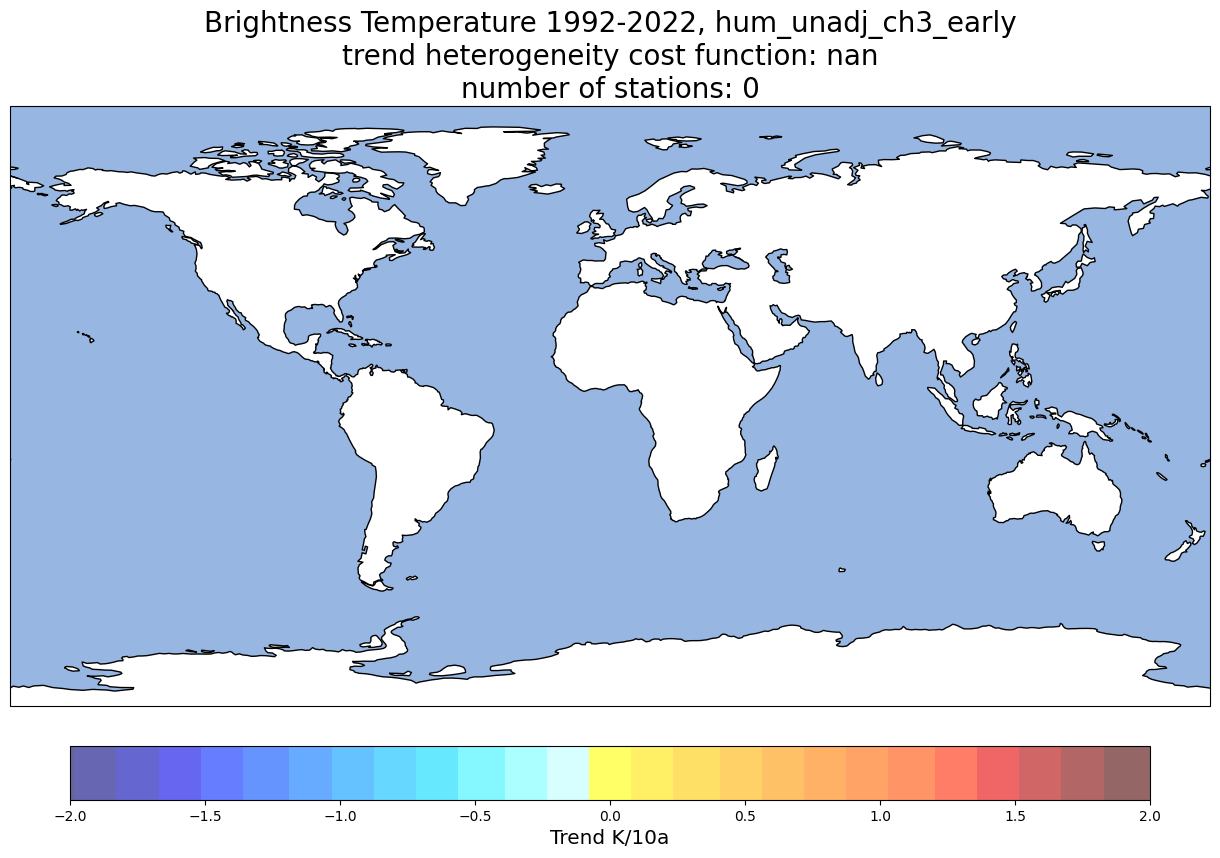

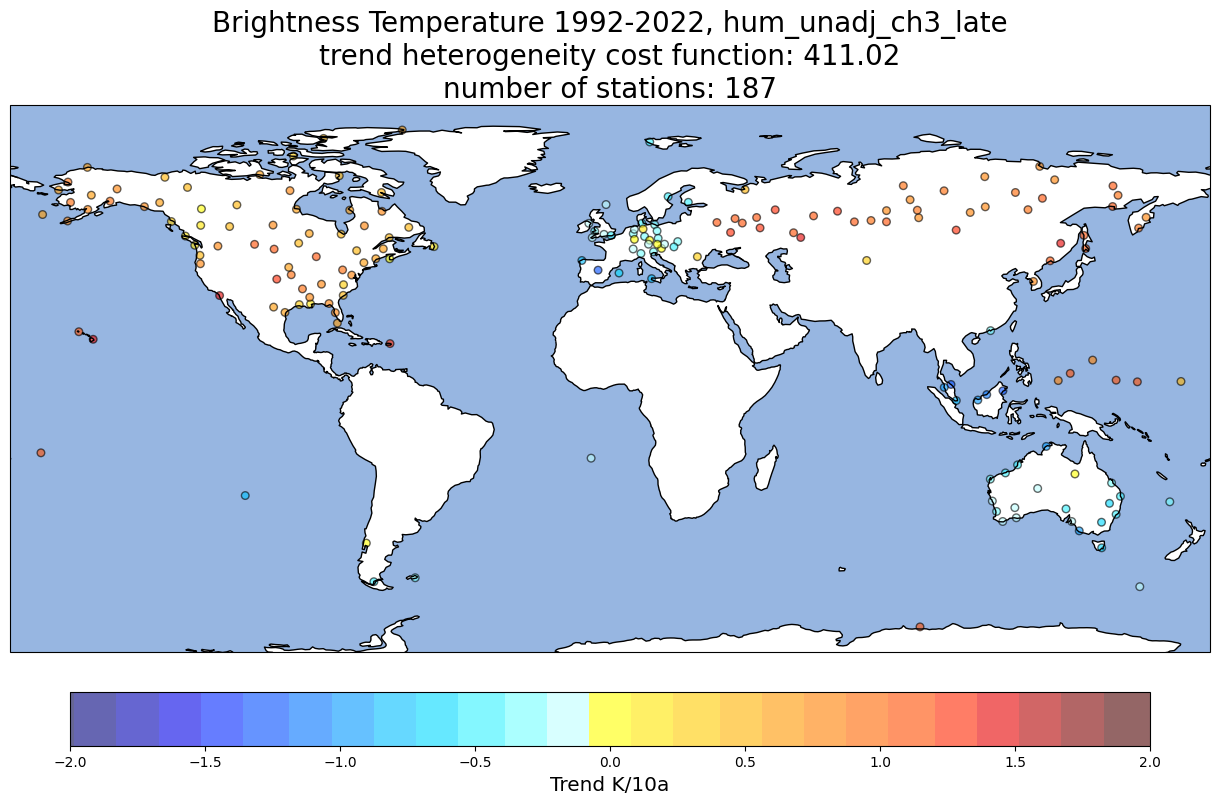

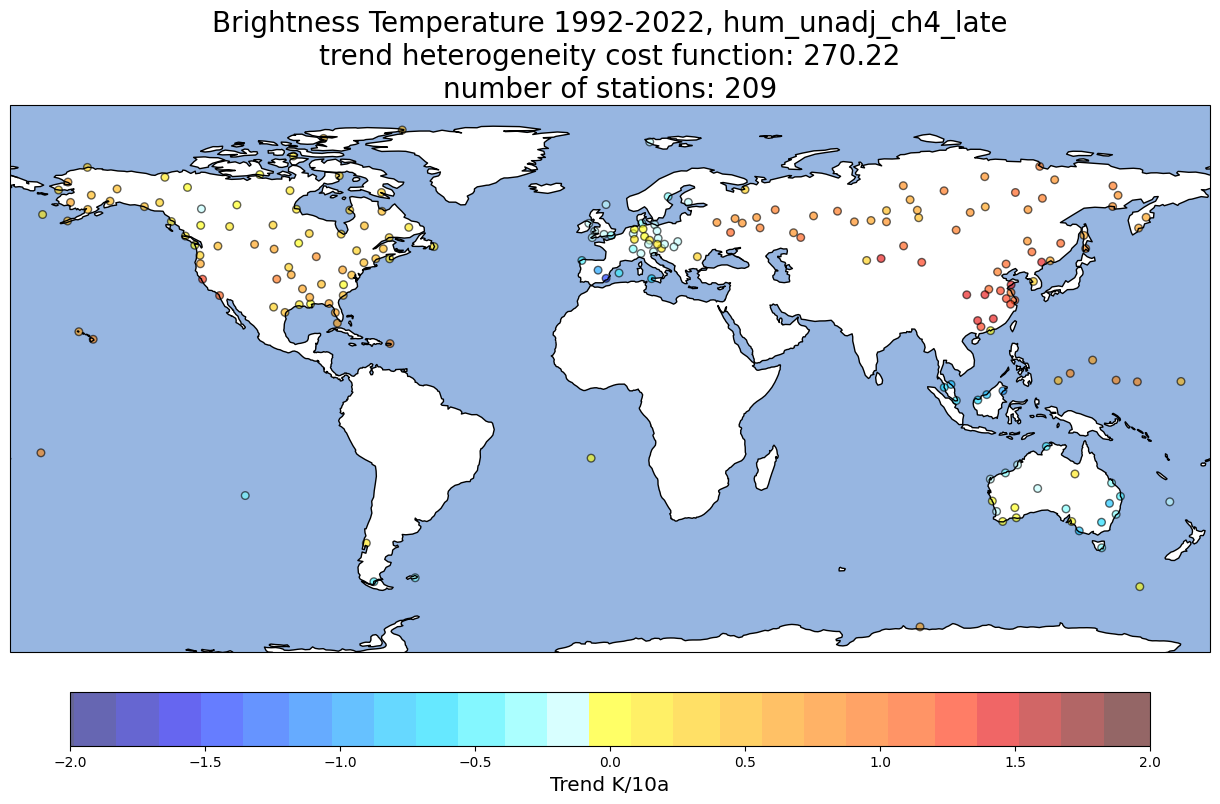

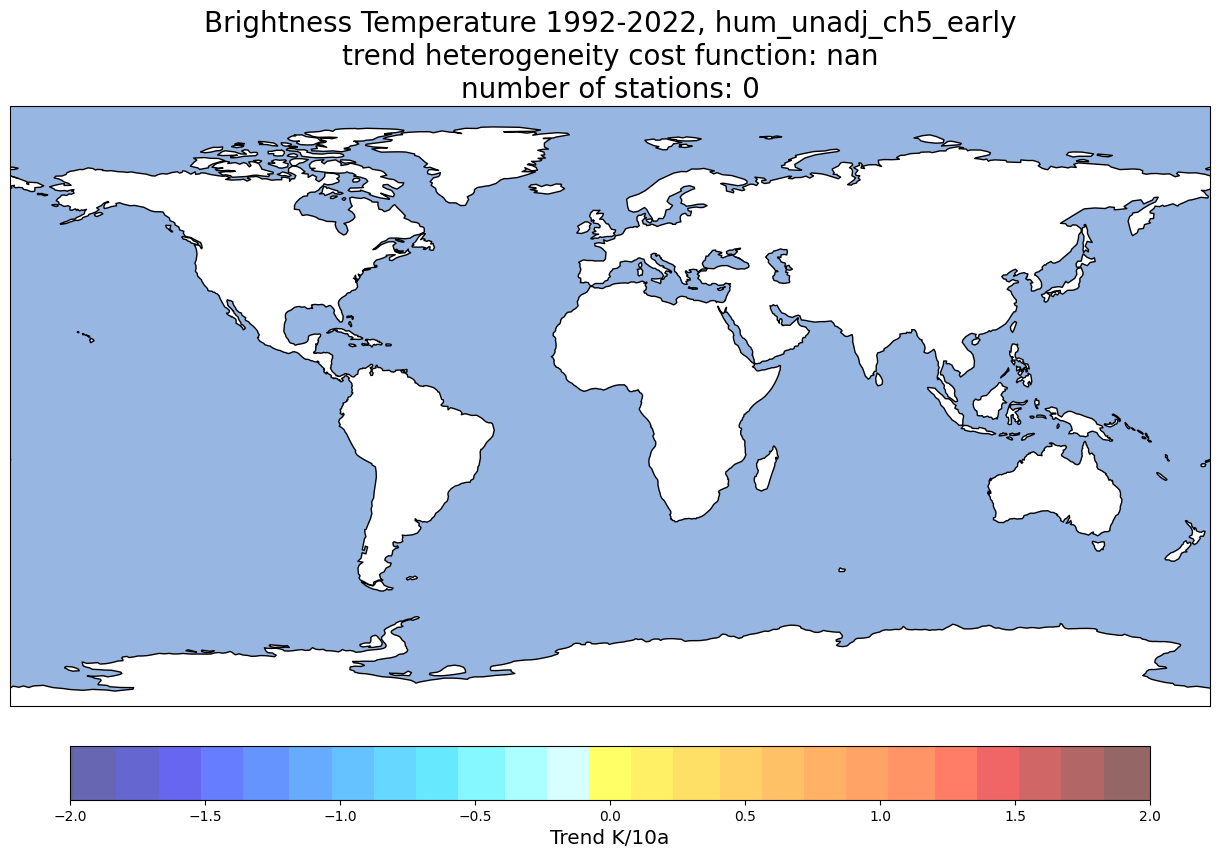

In [21]:
for k in ['ch3', 'ch4', 'ch5']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/*'+k+'*.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 30, marker_shape = 'o', alpha = 0.6 )

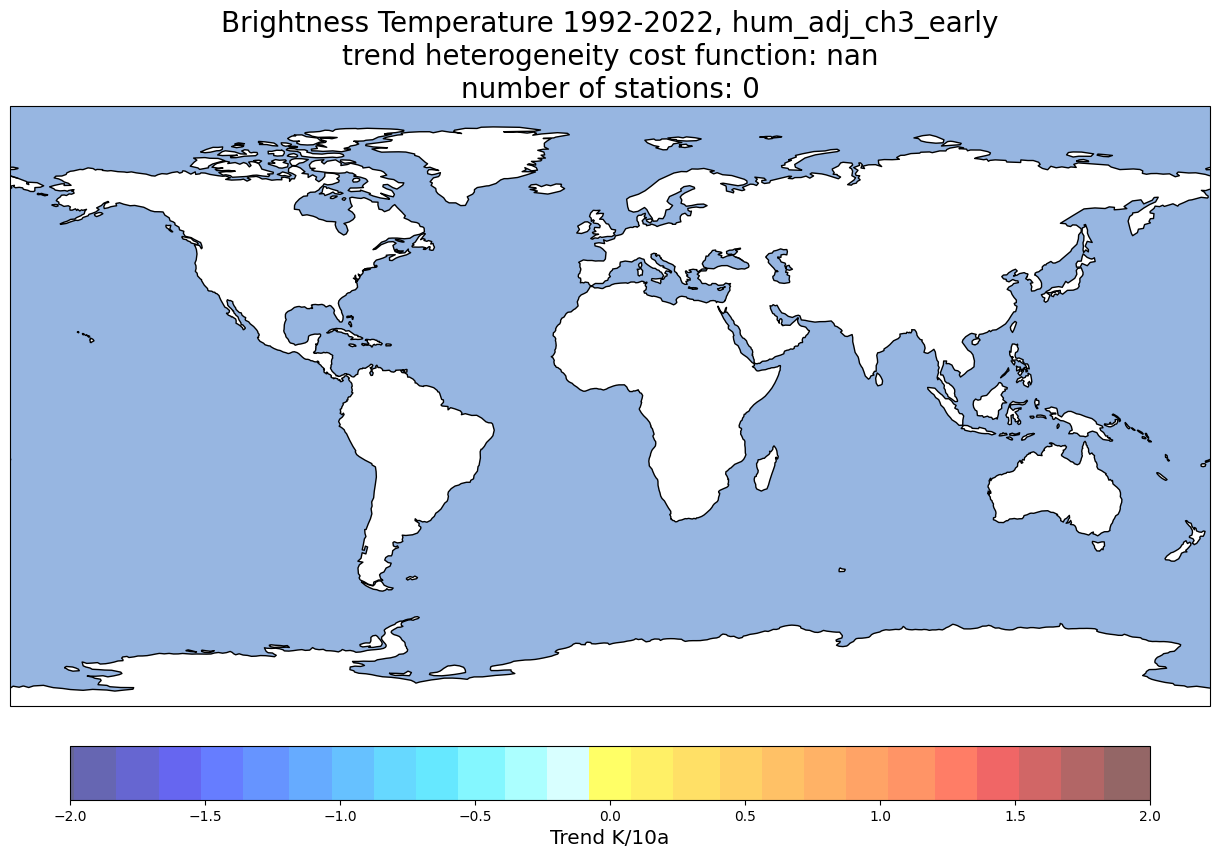

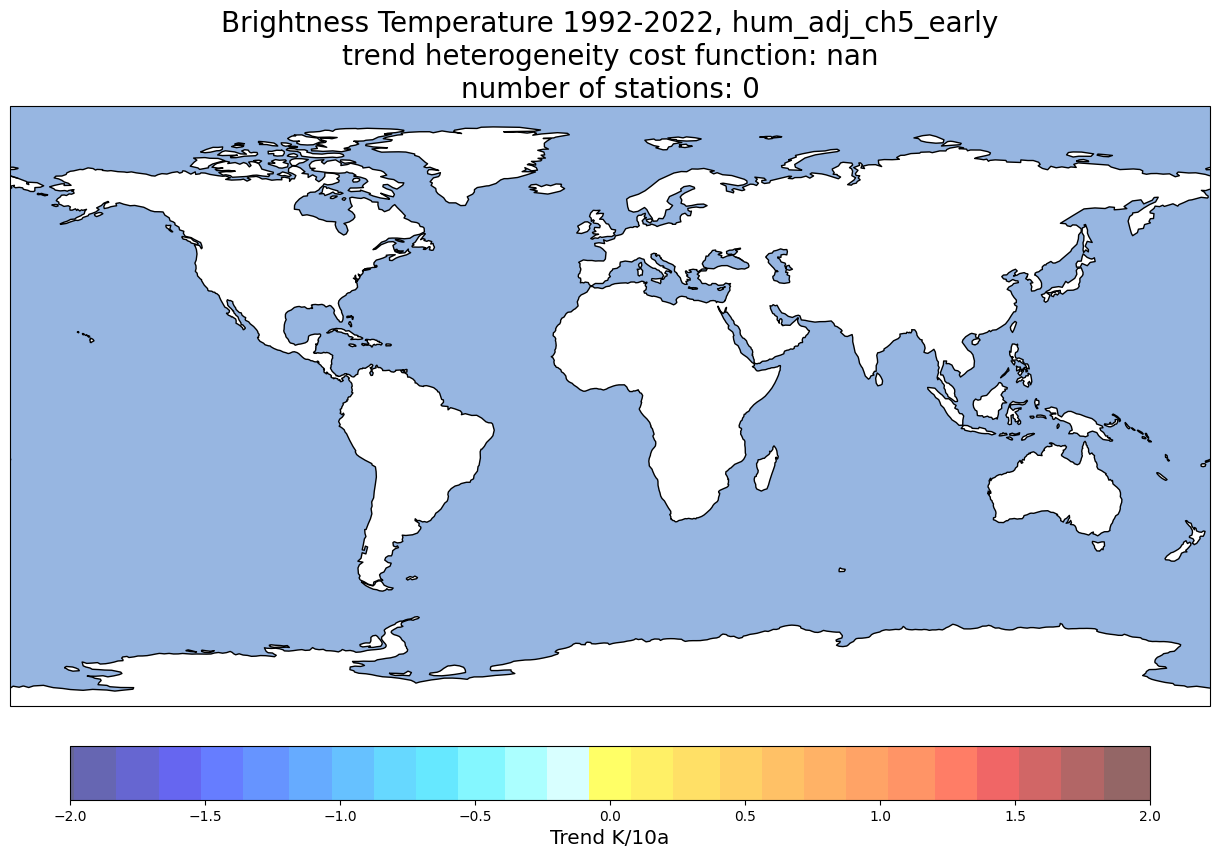

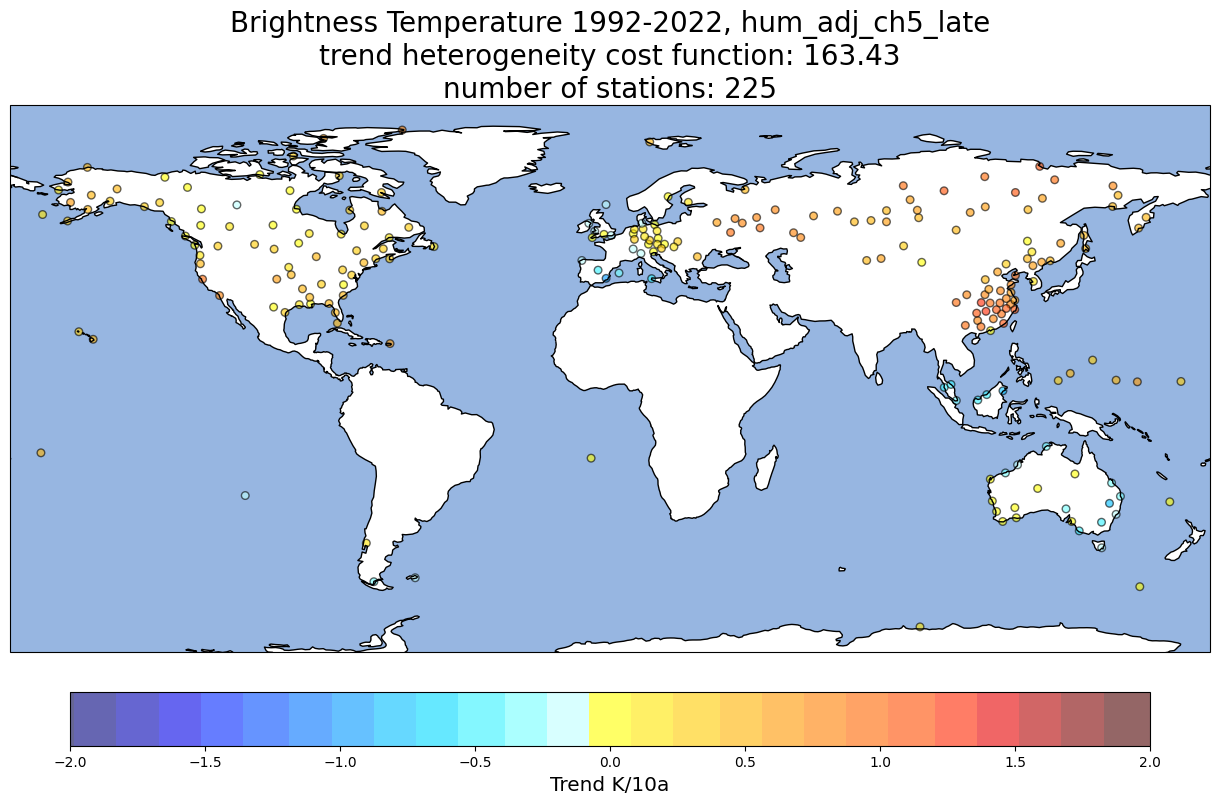

In [22]:
for k in ['ch3', 'ch4', 'ch5']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/*'+k+'*.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 30, marker_shape = 'o', alpha = 0.6 )